In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

print(torch.cuda.get_device_name())
print(torch.__version__, torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

NVIDIA RTX A2000 8GB Laptop GPU
2.0.0+cu118 True
cuda:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
x_data = pd.read_csv('../data/env1/first_quantile/first_quantile_x.csv', delimiter=',',encoding="utf-8-sig", header=None).values.tolist()
y_data = pd.read_csv('../data/env1/first_quantile/first_quantile_y.csv', delimiter=',',encoding="utf-8-sig", header=None).values.tolist()
theta_data = pd.read_csv('../data/env1/first_quantile/first_quantile_theta.csv', delimiter=',',encoding="utf-8-sig", header=None).values.tolist()

In [4]:
#make input data and ouptput data
input_data_1 = []
input_data_2 = []
output_data = []
max_seqence_length = 29
for i in range(np.shape(x_data)[0]):
    input_data_2_list = [x_data[i][0], x_data[i][-1], y_data[i][0], y_data[i][-1], theta_data[i][0], theta_data[i][-1]]
    for j in range(1, np.shape(x_data)[1]):
        x = x_data[i][0:j]
        y = y_data[i][0:j]
        input_data_1_list = []
        for k in range(len(x)):
            input_data_1_list.append([x[k], y[k]])
        for l in range(max_seqence_length-len(x)):
            input_data_1_list.append([0, 0])
        input_data_1.append(input_data_1_list)
        input_data_2.append(input_data_2_list)
        output_data.append([x_data[i][j], y_data[i][j]])


In [5]:
class MyDataset(Dataset):
    def __init__(self, input_data_1, input_data_2, output_data):
        super(MyDataset, self).__init__()
        self.input_data_1 = input_data_1
        self.input_data_2 = input_data_2
        self.output_data = output_data

    def __getitem__(self, index):
        input_1 = torch.tensor(self.input_data_1[index], dtype=torch.float32)
        input_2 = torch.tensor(self.input_data_2[index], dtype=torch.float32)
        output = torch.tensor(self.output_data[index], dtype=torch.float32)
        return input_1, input_2, output

    def __len__(self):
        return len(self.input_data_1)

In [6]:
train_valid_data = MyDataset(input_data_1, input_data_2, output_data)

val_size = int(0.2 * len(train_valid_data))
train_data, val_data = torch.utils.data.random_split(train_valid_data, [len(train_valid_data)-val_size, val_size])

In [7]:
val_size

36679

In [8]:
batch_size = 256

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

In [37]:
# dataの取り出し
Iter = dataloader_train.__iter__()
input_data1, input_data2, output_data = next(Iter)

print(input_data1.size())

torch.Size([256, 29, 2])


In [163]:
m = nn.LSTM(2, 32, num_layers=1, batch_first=True)
output, hidden_state = m(input_data1)
print(type(output))
print(hidden_state)
mm = nn.Linear(32, 10)
output1 = mm(output)
print(np.shape(output1))

<class 'torch.Tensor'>
2
torch.Size([256, 29, 10])


In [12]:
class LSTM_MLP(nn.Module):
    
    def __init__(
        self, 
        input1_size, 
        input2_size, 
        input_size,
        hidden1_size, 
        hidden2_size, 
        hidden_size,
        output1_size, 
        output2_size, 
        output_size,
        num_layers
        ):
        
        super(LSTM_MLP, self).__init__()
        self.hidden1_size = hidden1_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input1_size, hidden1_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden1_size, output1_size)
        
        self.mlp1 = nn.Sequential(
            nn.Linear(input2_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, output2_size)
        )
        
        self.mlp2 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, input1, input2):
        #RNN for input1
        h0 = torch.zeros(self.num_layers, input1.size(0), self.hidden1_size).to(input1.device)
        c0 = torch.zeros(self.num_layers, input1.size(0), self.hidden1_size).to(input1.device)
        
        output1, _ = self.lstm(input1, (h0, c0))
        output1 = self.fc(output1)

        #MLP for input2
        output2 = self.mlp1(input2)
        
        #output1とoutput2の結合
        output1 = output1.view(output1.size(0), -1)
        input = torch.cat((output1, output2), dim=1)
        
        #final MLP
        output = self.mlp2(input)
        
        return output

In [128]:
#model test
input1_size =  2
input2_size = 6
input_size = 29 * 2 + 16
hidden1_size = 32
hidden2_size = 32
hidden_size = 32
output1_size = 2
output2_size = 16
output_size = 2
num_layers = 1

model = LSTM_MLP(
        input1_size, 
        input2_size, 
        input_size,
        hidden1_size, 
        hidden2_size, 
        hidden_size,
        output1_size, 
        output2_size, 
        output_size,
        num_layers
        ).to(device)

In [13]:
Iter = dataloader_train.__iter__()
input_data1, input_data2, output_data = next(Iter)
input_data1, input_data2 = input_data1.to(device), input_data2.to(device)
output = model(input_data1, input_data2)
print(np.shape(output))

NameError: name 'model' is not defined

In [14]:
#ハイパーパラメータの設定
input1_size =  2
hidden1_size = 64
output1_size = 2

input2_size = 6
hidden2_size = 32
output2_size = 16

input_size = 29 * output1_size + output2_size
hidden_size = 32
output_size = 2

num_layers = 1
learning_rate = 0.001
num_epochs = 50


# モデルの定義
model = LSTM_MLP(
        input1_size, 
        input2_size, 
        input_size,
        hidden1_size, 
        hidden2_size, 
        hidden_size,
        output1_size, 
        output2_size, 
        output_size,
        num_layers
        ).to(device)

In [15]:
# 損失関数の定義
criterion = nn.MSELoss()

# オプティマイザの定義
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#トレーニングの開始
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    
    #train_mode
    model.train()
    for i, (input_data_1, input_data_2, output_data) in enumerate(dataloader_train):
        # データをGPUに転送
        input_data_1, input_data_2, output_data = input_data_1.to(device), input_data_2.to(device), output_data.to(device)
        
        # モデルの出力を計算
        output = model(input_data_1, input_data_2)
        
        # 損失関数の適用
        loss = criterion(output, output_data)
        
        #train_lossに結果を蓄積
        train_loss += loss.item()
        
        # 勾配を初期化して逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # lossの平均を計算
        avg_train_loss = train_loss  / len(dataloader_train.dataset)
        
    #valid_mode
    model.eval()
    with torch.no_grad():
        for input_data_1, input_data_2, output_data in dataloader_valid:
            # データをGPUに転送
            input_data_1, input_data_2, output_data = input_data_1.to(device), input_data_2.to(device), output_data.to(device)
            
            # モデルの出力を計算
            output = model(input_data_1, input_data_2)
            
            # 損失関数の適用
            loss = criterion(output, output_data)
        
            #val_lossに結果を蓄積
            val_loss += loss.item()
    
    # lossの平均を計算      
    avg_val_loss = val_loss / len(dataloader_valid.dataset)
    
    # print log
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}'.format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss))
    
    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)

Epoch [1/50], Loss: 0.0514, val_loss: 0.0019
Epoch [2/50], Loss: 0.0014, val_loss: 0.0012
Epoch [3/50], Loss: 0.0009, val_loss: 0.0008
Epoch [4/50], Loss: 0.0006, val_loss: 0.0007
Epoch [5/50], Loss: 0.0005, val_loss: 0.0005
Epoch [6/50], Loss: 0.0005, val_loss: 0.0005
Epoch [7/50], Loss: 0.0004, val_loss: 0.0004
Epoch [8/50], Loss: 0.0004, val_loss: 0.0004
Epoch [9/50], Loss: 0.0003, val_loss: 0.0004
Epoch [10/50], Loss: 0.0003, val_loss: 0.0003
Epoch [11/50], Loss: 0.0003, val_loss: 0.0003
Epoch [12/50], Loss: 0.0003, val_loss: 0.0003
Epoch [13/50], Loss: 0.0003, val_loss: 0.0004
Epoch [14/50], Loss: 0.0002, val_loss: 0.0003
Epoch [15/50], Loss: 0.0002, val_loss: 0.0002
Epoch [16/50], Loss: 0.0002, val_loss: 0.0002
Epoch [17/50], Loss: 0.0002, val_loss: 0.0002
Epoch [18/50], Loss: 0.0002, val_loss: 0.0003
Epoch [19/50], Loss: 0.0002, val_loss: 0.0002
Epoch [20/50], Loss: 0.0002, val_loss: 0.0003
Epoch [21/50], Loss: 0.0002, val_loss: 0.0002
Epoch [22/50], Loss: 0.0002, val_loss: 0.00

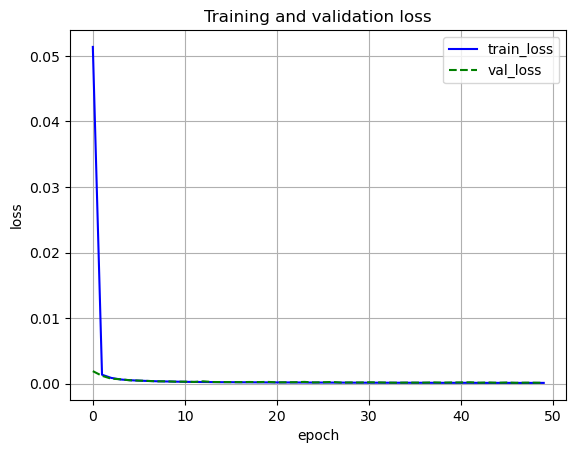

In [16]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

In [17]:
#save model
torch.save(model.state_dict(), '../saved_models/LSTM_MLP_env1_first_quantile.pth')

In [19]:
#read model
model = LSTM_MLP(
        input1_size, 
        input2_size, 
        input_size,
        hidden1_size, 
        hidden2_size, 
        hidden_size,
        output1_size, 
        output2_size, 
        output_size,
        num_layers
        ).to(device)
model.load_state_dict(torch.load('../saved_models/LSTM_MLP_env1_first_quantile.pth'))
print(model)

LSTM_MLP(
  (lstm): LSTM(2, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (mlp1): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (mlp2): Sequential(
    (0): Linear(in_features=74, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [29]:
class TestDataset(Dataset):
    def __init__(self, input_data_1, input_data_2):
        self.input_data_1 = input_data_1
        self.input_data_2 = input_data_2

    def __getitem__(self, index):
        input_1 = torch.tensor(self.input_data_1[index], dtype=torch.float32)
        input_2 = torch.tensor(self.input_data_2[index], dtype=torch.float32)
        output = 0
        return input_1, input_2, output

    def __len__(self):
        return len(self.input_data_1)

初期姿勢：88°, 終端姿勢：23°


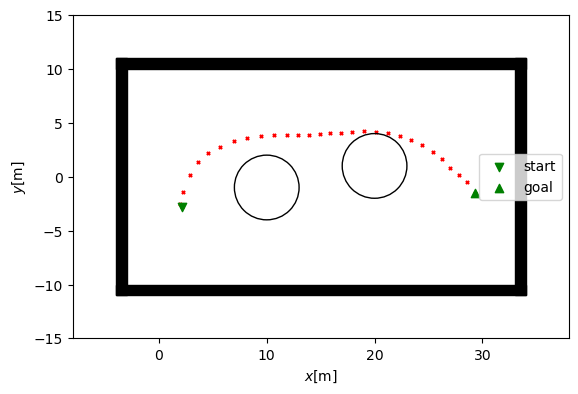

In [110]:
#test_pathの表示
import plot
import random

#入力のサンプリング
x_start = (random.uniform(-2, 4), random.uniform(-3, 3))  # Starting node
x_goal = (random.uniform(26, 32), random.uniform(-3, 3))  # Goal node

#env1用
theta_start = random.uniform(-np.pi/2, np.pi/2)
theta_goal = random.uniform(-np.pi/2, np.pi/2)

"""
#env2用
theta_start = random.uniform(np.pi/4, np.pi*3/4)
theta_goal = random.uniform(np.pi/4, np.pi*3/4)
"""

input_data1 = [[x_start[0], x_start[1]]]
for i in range(28):
    input_data1.append([0, 0])
input_data1 = [input_data1]
input_data2 = [[x_start[0], x_goal[0], x_start[1], x_goal[1], theta_start, theta_goal]]

test_data = TestDataset(input_data1, input_data2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

#予測モード
for i in range(28):
    model.eval()
    with torch.no_grad():
        input_data_1, input_data_2, _ = next(iter(test_loader))
        input_data_1, input_data_2, output_data = input_data_1.to(device), input_data_2.to(device), output_data.to(device)
        output = model(input_data_1, input_data_2)
        
        input_data1[0][i+1] = output[0].tolist()
        test_data = TestDataset(input_data1, input_data2)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
    
input_data1[0].append([x_goal[0], x_goal[1]])
result = np.array(input_data1).squeeze()

x, y = np.array([]), np.array([])
for i in range(np.shape(result)[0]):
    x = np.append(x, result[i, 0])
    y = np.append(y, result[i, 1])

print("初期姿勢：{}°, 終端姿勢：{}°".format(int(np.degrees(theta_start)), int(np.degrees(theta_goal))))
plot.vis_path_env1(x, y)

In [60]:
import torch

# 入力シーケンスの長さ情報を持つテンソルを作成
sequence_lengths = [5, 3, 4, 2]
max_length = max(sequence_lengths)

# パディングされた入力データを作成
padded_data = torch.tensor([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 0, 0],
    [9, 10, 11, 12, 0],
    [13, 14, 0, 0, 0]
])

# マスク行列を作成
mask = torch.arange(max_length)[None, :] < torch.tensor(sequence_lengths)[:, None]

# マスクを適用
masked_data = padded_data.masked_fill(~mask, 0)

# マスキング後のデータを表示
print(masked_data)
mask

tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  0,  0],
        [ 9, 10, 11, 12,  0],
        [13, 14,  0,  0,  0]])


tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True, False, False, False]])

In [67]:
import torch
import torch.nn as nn

# 入力データの準備
sequence_length = 10
input_size = 5
batch_size = 3

# ダミーの入力データを作成
input_data = torch.randn(batch_size, sequence_length, input_size)
print(input_data[0])
# マスク行列を作成
mask = torch.BoolTensor(batch_size, sequence_length).random_(2)
print(mask)
# RNNモデルの定義
hidden_size = 16
num_layers = 2
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

# マスキングを適用
masked_data = input_data.masked_fill(~mask.unsqueeze(-1), 0)
print(masked_data[0])
# RNNに入力データを与える
output, _ = rnn(masked_data)
print(output.shape)
# 最後の時刻の出力のみを抽出
last_output = output[:, -1, :]

# 出力の形状を確認
print(last_output.shape)

tensor([[-0.8263, -2.4882, -1.5078,  0.1501, -0.1572],
        [-0.8034,  0.5775,  1.1898, -0.3128, -1.4233],
        [ 1.3559,  0.2188, -0.5595, -0.6823, -0.1455],
        [ 0.4141,  1.4183, -0.2231, -0.0487, -0.0754],
        [ 0.5687, -0.0037,  0.5884,  0.5862,  1.2589],
        [-0.9575,  1.3869, -0.2221, -1.4118, -0.0440],
        [-2.0236,  0.8857, -1.2723, -1.7515,  0.0409],
        [-1.0070, -0.2854, -0.1534,  0.0098, -1.8868],
        [-0.1829,  0.0071,  1.0832, -1.3796,  0.3947],
        [ 1.0453,  1.3606, -0.1794, -2.4775, -1.3317]])
tensor([[ True,  True, False, False, False,  True, False,  True,  True,  True],
        [False, False,  True, False, False, False,  True, False,  True, False],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True]])
tensor([[-0.8263, -2.4882, -1.5078,  0.1501, -0.1572],
        [-0.8034,  0.5775,  1.1898, -0.3128, -1.4233],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000